"""
Created on Tue Jul 20 19:42:06 2021
@author: Franck
"""

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.inspection import permutation_importance

from sklearn import metrics
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import precision_recall_curve, roc_curve

import matplotlib.pyplot as plt

In [2]:
DATA_PATH = os.path.join(os.getcwd(),"../Data")
DATA_PATH

'F:\\Dropbox\\Travaux_JAOTOMBO\\These_Sante_Publique\\Mimic3\\Codes\\../Data'

In [3]:
df_raw = pd.read_feather(os.path.join(DATA_PATH,"30_READM_UNPLANNED_DISCHARGE_ICU"))

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33316 entries, 0 to 33315
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            33316 non-null  int64         
 1   subject_id       33316 non-null  int64         
 2   hadm_id          33316 non-null  int64         
 3   admittime        33316 non-null  datetime64[ns]
 4   dischtime        33316 non-null  datetime64[ns]
 5   first_careunit   33316 non-null  object        
 6   last_careunit    33316 non-null  object        
 7   age              33316 non-null  float64       
 8   gender           33316 non-null  object        
 9   marital_status   31754 non-null  object        
 10  insurance        33316 non-null  object        
 11  diagnosis        33315 non-null  object        
 12  admission_type   33316 non-null  object        
 13  next_readmit_dt  33316 non-null  float64       
 14  target           33316 non-null  int32

In [5]:
df = df_raw.copy()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33316 entries, 0 to 33315
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            33316 non-null  int64         
 1   subject_id       33316 non-null  int64         
 2   hadm_id          33316 non-null  int64         
 3   admittime        33316 non-null  datetime64[ns]
 4   dischtime        33316 non-null  datetime64[ns]
 5   first_careunit   33316 non-null  object        
 6   last_careunit    33316 non-null  object        
 7   age              33316 non-null  float64       
 8   gender           33316 non-null  object        
 9   marital_status   31754 non-null  object        
 10  insurance        33316 non-null  object        
 11  diagnosis        33315 non-null  object        
 12  admission_type   33316 non-null  object        
 13  next_readmit_dt  33316 non-null  float64       
 14  target           33316 non-null  int32

=============================================================================<br>
 Unstructured dataset<br>
=============================================================================<br>

In [11]:
X = df["text_final"]

In [12]:
y = df["target"]

Outcome category frequency

In [14]:
print(y.value_counts())
print(y.value_counts() / len(y))

0    31974
1     1342
Name: target, dtype: int64
0    0.959719
1    0.040281
Name: target, dtype: float64


In [13]:
# Start working with a subset of 10% of the full data
# _, X, _, y = train_test_split(X, y, test_size=0.1, shuffle=True, stratify = y, random_state=42)

In [15]:
X.shape, y.shape

((33316,), (33316,))

In [16]:
MAX_FEATURES = 5000
N_GRAM = (1,2)
RANDOM_STATE = 42

Create data partition between training and test sets

In [17]:
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, stratify = y, random_state=RANDOM_STATE)

In [18]:
print(y_full_train.value_counts())
print(y_full_train.value_counts() / len(y_full_train))

0    28776
1     1208
Name: target, dtype: int64
0    0.959712
1    0.040288
Name: target, dtype: float64


TF-IDF Document to Terms Transformation

In [19]:
def tfidf_features(X_train, X_test):
    """
        X_train, X_test samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    tfidf_vectorizer = TfidfVectorizer(ngram_range=N_GRAM, min_df=5, max_df=0.80, max_features=MAX_FEATURES)
    
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_test = tfidf_vectorizer.transform(X_test)
   
    return X_train, X_test, tfidf_vectorizer.vocabulary_, tfidf_vectorizer.get_feature_names()

Transform the full training and the test sets into TF IDF features

In [20]:
X_train_tfidf, X_test_tfidf, tfidf_vocab, tfidf_features_names = tfidf_features(X_full_train, X_test)

E:\Anaconda3\envs\text\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [21]:
X_train_tfidf.shape

(29984, 5000)

**Lasso Variable Selection**

In [22]:
lasso = LogisticRegression(max_iter=300, solver="saga", penalty="l1", n_jobs=-1, random_state=RANDOM_STATE)

In [23]:
lasso.fit(X_train_tfidf, y_full_train)

LogisticRegression(max_iter=300, n_jobs=-1, penalty='l1', random_state=42,
                   solver='saga')

In [24]:
lasso.coef_.shape

(1, 5000)

In [25]:
lasso_coef = pd.DataFrame(lasso.coef_, columns = tfidf_features_names, index=["coefficients"])

In [26]:
lasso_coef

,aaa,ab,abd,abd pain,abd pelvis,abd soft,abdoman,abdoman pelvis,abdoman soft,abdomen,...,yo,yr,yr ago,zantac,zestril,zocor,zofran,zoloft,zosyn,zyprexa
coefficients,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
lasso_imp = (lasso_coef.T.abs()/lasso_coef.T.abs().max()).sort_values(by="coefficients",ascending=False)*100

In [28]:
lasso_imp

,coefficients
hospice,100.000000
moderate,62.450351
primary care,61.951949
transfer hospital,57.502251
tid,44.090543
...,...
facility,0.000000
facial droop,0.000000
facial,0.000000
face,0.000000


In [29]:
lasso_select = lasso_imp[lasso_imp["coefficients"] != 0]

In [30]:
len(lasso_select)

188

In [31]:
lasso_var_select = list(lasso_select.index)
lasso_var_select[:30]

['hospice',
 'moderate',
 'primary care',
 'transfer hospital',
 'tid',
 'trach',
 'subdural',
 'tracheostomy',
 'mesenteric',
 'bilateral',
 'slightly',
 'overdose',
 'cpap',
 'building',
 'vision',
 'peg',
 'tube feed',
 'recently',
 'heparin',
 'disp',
 'flush',
 'surgery',
 'sputum',
 'increase',
 'control',
 'amiodarone',
 'clip',
 'symptom',
 'outside',
 'pacer']

% Tuning of the Classifier

In [32]:
REPEAT = 5

In [33]:
X_tfidf = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf, columns = tfidf_features_names)
X = X_tfidf[lasso_var_select]

In [34]:
train = []
for i in range(REPEAT):
     train.append(train_test_split(X, y_full_train,
                                   test_size=0.2,
                                   shuffle=True,
                                   stratify = y_full_train))

### Elasticnet

initialize elasticnet

In [35]:
en_auc = []
en_accuracy = []
en_impMat = []
en_proba = pd.DataFrame({'A' : []})
en_class = pd.DataFrame({'A' : []})
en_best = []
en_params = []

for repeat, [X_train, X_val, y_train, y_val] in enumerate(train) :
    
    print("\nRépétition : {}".format(repeat+1))
      
    param_en = {'C': np.logspace(-3, 4, 10), 'l1_ratio':np.linspace(0,1,11) }
        
    # Instantiate the Logistic Regression Classifier : en
    en = LogisticRegression(max_iter=500, penalty ='elasticnet', solver='saga', random_state = RANDOM_STATE)
    
    grid_en = RandomizedSearchCV(en, param_en, cv=5, n_jobs=-1, 
                          scoring=['accuracy','roc_auc'], refit = 'roc_auc')
       
    # Fit the model to the training data
    grid_en.fit(X_train, y_train)
    
    # Select the best model
    best_en = grid_en.best_estimator_
    en_best.append(best_en)
      
    # Compute predicted probabilities: y_pred_proba
    en_pred_proba = pd.DataFrame(best_en.predict_proba(X_val)[:,1])
    en_pred_class = pd.DataFrame(best_en.predict(X_val))
    en_proba = pd.concat([en_proba,en_pred_proba], axis=1)
    en_class = pd.concat([en_class,en_pred_class], axis=1)

    # Print the optimal parameters and best score
    print("Tuned Regularized Logistic Regression Parameters: {}".format(grid_en.best_params_))
    print("Tuned Regularized Logistic Regression Accuracy: {}".format(accuracy_score(y_val, en_pred_class)))
    print("Tuned Regularized Logistic Regression AUC: {}".format(roc_auc_score(y_val, en_pred_proba)))

    # Save the parameters
    en_params.append(grid_en.best_params_)
    
    # Compute scores
    en_accuracy.append(accuracy_score(y_val, en_pred_class))
    en_auc.append(roc_auc_score(y_val, en_pred_proba))
    
    # Compute permutation scores
    en_imp = permutation_importance(best_en, X_val, y_val, scoring='roc_auc')
    en_impMat.append(en_imp.importances_mean)


Répétition : 1
Tuned Regularized Logistic Regression Parameters: {'l1_ratio': 0.1, 'C': 10000.0}
Tuned Regularized Logistic Regression Accuracy: 0.9596464899116225
Tuned Regularized Logistic Regression AUC: 0.7448808438224758

Répétition : 2
Tuned Regularized Logistic Regression Parameters: {'l1_ratio': 0.8, 'C': 46.41588833612782}
Tuned Regularized Logistic Regression Accuracy: 0.95981323995331
Tuned Regularized Logistic Regression AUC: 0.7298346389413446

Répétition : 3
Tuned Regularized Logistic Regression Parameters: {'l1_ratio': 0.0, 'C': 278.2559402207126}
Tuned Regularized Logistic Regression Accuracy: 0.959479739869935
Tuned Regularized Logistic Regression AUC: 0.710785447077999

Répétition : 4
Tuned Regularized Logistic Regression Parameters: {'l1_ratio': 0.5, 'C': 1668.100537200059}
Tuned Regularized Logistic Regression Accuracy: 0.9593129898282474
Tuned Regularized Logistic Regression AUC: 0.7261913822691013

Répétition : 5
Tuned Regularized Logistic Regression Parameters: 

%

In [36]:
X_tfidf_test = pd.DataFrame.sparse.from_spmatrix(X_test_tfidf, columns = tfidf_features_names)   
X_test = X_tfidf_test[lasso_var_select]

In [37]:
X_test

,hospice,moderate,primary care,transfer hospital,tid,trach,subdural,tracheostomy,mesenteric,bilateral,...,hepatic,pm blood,develop,qd,octreotide,prn,cr,staphylococcus,tablet mouth,liver
0,0.0,0.022726,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.024872,0.000000,0.0,0.138570,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.019802,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.102145,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.0,0.012243,0.000000,0.013109,0.000000,0.000000,0.0,0.000000,0.000000,0.023121,...,0.0,0.000000,0.000000,0.000000,0.0,0.011534,0.00000,0.000000,0.000000,0.000000
4,0.0,0.041313,0.000000,0.014746,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.039684,0.000000,0.0,0.038922,0.08616,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3327,0.0,0.044074,0.015229,0.000000,0.032470,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.013841,0.00000,0.032348,0.000000,0.000000
3328,0.0,0.000000,0.000000,0.000000,0.025988,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.100105,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
3329,0.0,0.038430,0.000000,0.000000,0.016987,0.116264,0.0,0.015773,0.016434,0.029031,...,0.0,0.000000,0.022149,0.010906,0.0,0.028965,0.00000,0.000000,0.000000,0.019903
3330,0.0,0.032428,0.042019,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.007655,...,0.0,0.000000,0.000000,0.046012,0.0,0.000000,0.00000,0.000000,0.015398,0.000000


-------------------<br>
Elasticnet<br>
-------------------<br>
Compute mean probability prediction :

In [38]:
en_proba_mean = en_proba.mean(axis=1)
en_class_mean = en_class.mean(axis=1)
    
# Compute and print mean AUC score
en_meanAccuracy = np.mean(en_accuracy)
print("'\n' average Accuracy for the penalized Logistic Regression: {:.3f}".format(en_meanAccuracy))

'
' average Accuracy for the penalized Logistic Regression: 0.960


In [39]:
en_meanAuc = np.mean(en_auc) 
print("'\n' average AUC for the penalized Logistic Regression: {:.3f}".format(en_meanAuc))

'
' average AUC for the penalized Logistic Regression: 0.729


In [40]:
en_scoreData = pd.DataFrame( {'Accuracy':[en_meanAccuracy], 'ROC AUC':[en_meanAuc]})
en_impMean = np.mean(en_impMat, axis=0)
en_impData = pd.DataFrame({'Modalities':X_test.columns, 'Importance':en_impMean/en_impMean.max()*100})

In [41]:
en_result = en_impData.sort_values(by=['Importance'], ascending=False)[:20]

In [42]:
print("\n average Importance for the Elasticnet Regression \n{}".format(en_result))


 average Importance for the Elasticnet Regression 
            Modalities  Importance
0              hospice  100.000000
11            overdose   56.132718
6             subdural   36.463897
2         primary care   35.112351
27             symptom   28.910391
121            advance   28.462309
14              vision   26.741393
10            slightly   25.458291
30           lorazepam   24.449879
39       tablet tablet   23.202141
24             control   22.930874
56                 sig   22.357539
3    transfer hospital   21.752492
50            aneurysm   20.885075
21             surgery   20.695713
43                  po   18.834942
133             po prn   18.495002
88               stent   18.480173
4                  tid   18.474013
25          amiodarone   17.883795


% Evaluating Test Sample

In [43]:
best_en = en_best[en_auc.index(max(en_auc))]
en_test_pred = best_en.predict(X_test)
en_test_pred_proba = best_en.predict_proba(X_test)
en_test_accuracy = accuracy_score(y_test, en_test_pred)
en_test_auc = roc_auc_score(y_test, en_test_pred_proba[:,1])

In [44]:
en_best_params = en_params[en_auc.index(max(en_auc))]

In [45]:
print("'\n' Performance sur l'échantillon Test - Accuracy : {:.3f}".format(en_test_accuracy))
print("'\n' Performance sur l'échantillon Test - ROC : {:.3f}".format(en_test_auc))
print("'\n' Best Parameters :", en_best_params)

'
' Performance sur l'échantillon Test - Accuracy : 0.959
'
' Performance sur l'échantillon Test - ROC : 0.675
'
' Best Parameters : {'l1_ratio': 0.1, 'C': 10000.0}


In [46]:
from sklearn.metrics import confusion_matrix, classification_report

In [47]:
confusion_df = pd.DataFrame(confusion_matrix(y_test, en_test_pred), index=["No","Yes"], columns=["No","Yes"])
confusion_df

,No,Yes
No,3196,2
Yes,134,0


In [48]:
print(classification_report(y_test, en_test_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3198
           1       0.00      0.00      0.00       134

    accuracy                           0.96      3332
   macro avg       0.48      0.50      0.49      3332
weighted avg       0.92      0.96      0.94      3332



### Critics and Observations

Case where max_df = 0.9

It appears that the cleaning of the text requires more work (too many "stopwords" remaining)

So far, after removing more stopwords, we have kept max_df = 0.5


In [49]:
def precision_recall_curve_with_threshold(targets, probas, threshold = 0.5):
    
    def sort_pair(X, Y):
        rangee = [(x, y) for x, y in sorted(zip(X, Y), key = lambda pair: pair[0])]
        return [pair[0] for pair in rangee], [pair[1] for pair in rangee]
    
    # --- main
    targets, probas = sort_pair(targets, probas)
    precision, recall, thresholds = metrics.precision_recall_curve(targets, probas, pos_label="Yes")
    
    # calculate precision-recall AUC
    auc_val = metrics.auc(recall, precision)
    print('Area Under PRC Curve (AUC) : {:.3f}'.format(auc_val))
    # plot no skill
    if threshold is not None : 
        index = len([y for y in thresholds if y <= threshold]) # thresholds are sorted

        print('Recall with threshold = {}: {:.2f}%'.format(threshold, recall[index]*100))
        print('Precision with threshold = {} : {:.2f}%'.format(threshold, precision[index]*100))

        plt.plot([0, 1], [precision[index], precision[index]], linestyle='--', color = 'grey')
        plt.plot([recall[index], recall[index]], [0, 1], linestyle='--', color = 'grey')
        
        # plot the precision-recall curve for the model
        plt.plot(recall[:index], precision[:index], color = 'navy', marker='.')
        plt.plot(recall[index:], precision[index:], color = 'orange', marker='.')
        
        # show the plot
        plt.title('Precision-Recall curve with threshold = {}'.format(threshold))
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')
    else :
        # plot the precision-recall curve for the model
        plt.plot(recall, precision, color = 'orange', marker='.')
        
        # show the plot
        plt.title('Precision-Recall curve')
        plt.xlabel('Recall $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('Precision $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')

    plt.show()
    return

In [50]:
def roc_auc_curve_with_threshold(targets, probas, threshold = 0.5):
    
    def sort_pair(X, Y):
        rangee = [(x, y) for x, y in sorted(zip(X, Y), key = lambda pair: pair[0])]
        return [pair[0] for pair in rangee], [pair[1] for pair in rangee]
    
    # --- main
    targets, probas = sort_pair(targets, probas)
    fpr, tpr, thresholds = metrics.roc_curve(targets, probas, pos_label="Yes")
    
    # calculate precision-recall AUC
    auc_val = metrics.auc(fpr, tpr)
    print('Area Under ROC Curve (AUC) : {:.3f}'.format(auc_val))
    # plot no skill
    if threshold is not None : 
        index = len([y for y in thresholds if y <= threshold]) # thresholds are sorted

        print('FPR with threshold = {}: {:.2f}%'.format(threshold, fpr[index]*100))
        print('TPR with threshold = {} : {:.2f}%'.format(threshold, tpr[index]*100))

        plt.plot([0, 1], [tpr[index], tpr[index]], linestyle='--', color = 'grey')
        plt.plot([fpr[index], fpr[index]], [0, 1], linestyle='--', color = 'grey')
        
        # plot the precision-recall curve for the model
        plt.plot(fpr[:index], tpr[:index], color = 'navy', marker='.')
        plt.plot(fpr[index:], tpr[index:], color = 'orange', marker='.')
        
        # show the plot
        plt.title('ROC AUC curve with threshold = {}'.format(threshold))
        plt.xlabel('False Positive Rate $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('True Positive Rate $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')
    else :
        # plot the precision-recall curve for the model
        plt.plot(recall, precision, color = 'orange', marker='.')
        
        # show the plot
        plt.title('ROC AUC curve')
        plt.xlabel('False Positive Rate $P(\, \widehat{1}\, | 1)$')
        plt.ylabel('True Positive Rate $P(\, 1\, | \widehat{1})$                                ', rotation = 'horizontal')

    plt.show()
    return

E:\Anaconda3\envs\text\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


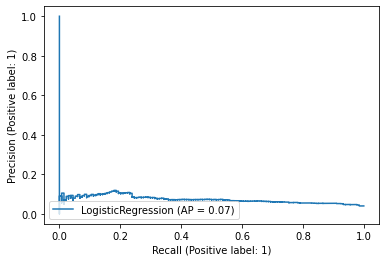

In [51]:
prc_auc_curve = plot_precision_recall_curve(best_en, X_test, y_test)
prc_auc_curve;

E:\Anaconda3\envs\text\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


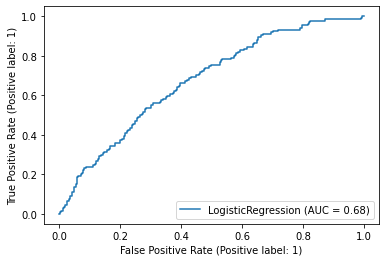

In [52]:
roc_auc_curve = plot_roc_curve(best_en, X_test, y_test)
roc_auc_curve;

In [56]:
# best prc threshold
yhat = best_en.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, yhat, pos_label="Yes")
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.nanargmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

E:\Anaconda3\envs\text\lib\site-packages\sklearn\metrics\_ranking.py:751: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_true = y_true == pos_label


TypeError: 'bool' object is not subscriptable

In [57]:
fscore

NameError: name 'fscore' is not defined

In [55]:
probas = best_en.predict_proba(X_test)[:, 1]
precision_recall_curve_with_threshold(y_test, probas, threshold = thresholds[ix])

NameError: name 'thresholds' is not defined

In [57]:
# best prc threshold
yhat = best_en.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat, pos_label="Yes")
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.118173, G-Mean=0.672


Area Under ROC Curve (AUC) : 0.712
FPR with threshold = 0.11817266645286537: 13.24%
TPR with threshold = 0.11817266645286537 : 36.51%


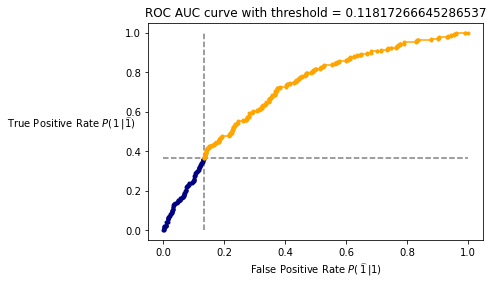

In [58]:
probas = best_en.predict_proba(X_test)[:, 1]
roc_auc_curve_with_threshold(y_test, probas, threshold = thresholds[ix])

In [59]:
def confusion_threshold(classifier, threshold, X_test, y_test, labels=["No","Yes"]) :
    pred = ["Yes" if ( proba > threshold ) else "No" for proba in classifier.predict_proba(X_test)[:,1]]
    confusion_df = pd.DataFrame(confusion_matrix(y_test, pred), index=["No","Yes"], columns=["No","Yes"])
    print(classification_report(y_test,pred))
    return confusion_df

In [60]:
confusion_threshold(best_en, 0.5, X_test, y_test, labels=["No","Yes"])

              precision    recall  f1-score   support

          No       0.87      0.99      0.92      1609
         Yes       0.38      0.06      0.10       252

    accuracy                           0.86      1861
   macro avg       0.62      0.52      0.51      1861
weighted avg       0.80      0.86      0.81      1861



,No,Yes
No,1586,23
Yes,238,14


In [61]:
confusion_threshold(best_en, 0.21565546996069843, X_test, y_test, labels=["No","Yes"])

              precision    recall  f1-score   support

          No       0.90      0.86      0.88      1609
         Yes       0.31      0.41      0.36       252

    accuracy                           0.80      1861
   macro avg       0.61      0.64      0.62      1861
weighted avg       0.82      0.80      0.81      1861



,No,Yes
No,1380,229
Yes,148,104


In [62]:
confusion_threshold(best_en, 0.11817266645286537, X_test, y_test, labels=["No","Yes"])

              precision    recall  f1-score   support

          No       0.93      0.62      0.75      1609
         Yes       0.23      0.72      0.35       252

    accuracy                           0.64      1861
   macro avg       0.58      0.67      0.55      1861
weighted avg       0.84      0.64      0.69      1861



,No,Yes
No,1005,604
Yes,71,181


In [64]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_classifier = CalibratedClassifierCV(
    base_estimator = best_en,
    method = 'sigmoid', # 'sigmoid' or 'isotonic'
    ensemble = False,
    cv = 8, # int of 'prefit'
    n_jobs = -1,
)

In [65]:
%time calibrated_classifier.fit(X_train, y_train)

Wall time: 7.93 s


CalibratedClassifierCV(base_estimator=LogisticRegression(C=7.742636826811269,
                                                         l1_ratio=0.5,
                                                         max_iter=500,
                                                         penalty='elasticnet',
                                                         random_state=42,
                                                         solver='saga'),
                       cv=8, ensemble=False, n_jobs=-1)

In [66]:
def specificity_score(y_true, y_predict):
    '''
    Computes the proba that a label is 0 knowing that the prediction is 0
    '''
    y_predict_0  = [(pred, true) for pred, true in zip(y_predict, y_true) if true == "No"]
    y_predict_00 = [(pred, true) for pred, true in y_predict_0 if pred == "No"]
    specificity  = (0 if len(y_predict_0) == "No" else len(y_predict_00)/len(y_predict_0))
    return specificity

In [67]:
y_predict_test = calibrated_classifier.predict(X_test)

acc = metrics.accuracy_score(y_test, y_predict_test)
rec = metrics.recall_score(y_test, y_predict_test, pos_label="Yes")
prc = metrics.precision_score(y_test, y_predict_test, pos_label="Yes")
spe = specificity_score(y_test, y_predict_test)
f1  = metrics.f1_score(y_test, y_predict_test, pos_label="Yes")

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

Accuracy : 86.03%
Recall : 3.17%
Precision : 33.33%
Specificity : 99.01%
F1-score : 5.80%


In [68]:
confusion_threshold(calibrated_classifier, 0.5, X_test, y_test, labels=["No","Yes"])

              precision    recall  f1-score   support

          No       0.87      0.99      0.92      1609
         Yes       0.33      0.03      0.06       252

    accuracy                           0.86      1861
   macro avg       0.60      0.51      0.49      1861
weighted avg       0.79      0.86      0.81      1861



,No,Yes
No,1593,16
Yes,244,8


In [69]:
confusion_threshold(calibrated_classifier, 0.21565546996069843, X_test, y_test, labels=["No","Yes"])

              precision    recall  f1-score   support

          No       0.90      0.86      0.88      1609
         Yes       0.31      0.40      0.35       252

    accuracy                           0.80      1861
   macro avg       0.60      0.63      0.61      1861
weighted avg       0.82      0.80      0.81      1861



,No,Yes
No,1384,225
Yes,152,100


In [70]:
confusion_threshold(calibrated_classifier, 0.11817266645286537, X_test, y_test, labels=["No","Yes"])

              precision    recall  f1-score   support

          No       0.93      0.61      0.74      1609
         Yes       0.22      0.73      0.34       252

    accuracy                           0.62      1861
   macro avg       0.58      0.67      0.54      1861
weighted avg       0.84      0.62      0.68      1861



,No,Yes
No,975,634
Yes,69,183
